## Use the same blocks for the kawasaki test run analysis
---
### Starting here:

In [1]:
from mplh.fig_utils import helper_save

from os.path import join, basename, exists
import os
import yaml
import pandas as pd 
import numpy as np
import pickle
from glob import glob
%load_ext autoreload
%autoreload 2

fig_utils from mplh


In [2]:
from src.config import DATA_DIR, PARAMS_DIR, RESULTS
print(DATA_DIR)


Project Directory: /data2/isshamie/time_neutrophils
/data2/isshamie/time_neutrophils/data


In [3]:
#The parameter file depending on the analysis
parameter_f = join(PARAMS_DIR, "kawasaki", "test_run", "kawasaki_snakemake_A1B1.yaml")
# with open(parameter_f,'r') as f:
#     params = yaml.load(f, Loader=yaml.Loader)
with open(parameter_f, 'r') as f:
    params = yaml.safe_load(f)

print(parameter_f)
print(params)

/data2/isshamie/time_neutrophils/parameters/kawasaki/test_run/kawasaki_snakemake_A1B1.yaml
{'raw_dir': 'raw/kawasaki/FCS Files/', 'prefix': 'kawasaki/test_run/A1B1', 'tidy_name': 'tidy', 'wells': ['A01', 'B01'], 'name': {'start': 'Test Run - ', 'end': '.csv'}, 'features': ['Cell Tracker Intensity', 'PI Intensity', 'AnexinV Intensity', 'Cell Aspect Ratio', 'Cell Size', 'Cell Circularity'], 'normalizations': ['log10_z'], 'reduction': 'umap', 'n_subsample': 0, 'n_iters': 3, 'min_neighbors': [15, 200, 100], 'min_distances': [0], 'cluster_technique': 'hdb', 'min_cluster_size': [30, 60], 'min_sample': [100]}


### Make results directory 

In [4]:
results_dir =  join(RESULTS, params["prefix"])
print(results_dir)
if not exists(RESULTS):
    print(f"{RESULTS} is not made yet! Make that first")

else:
    if not exists(results_dir):
        os.makedirs(results_dir)

/data2/isshamie/time_neutrophils/data/processed/kawasaki/test_run/A1B1


In [5]:
eda_dir = join(results_dir, "eda")
if not exists(eda_dir):
    os.mkdir(eda_dir)

### Until Here
---
---

### Outdir is PCA dir

In [6]:
pca_dir = join(results_dir, "pca")
if not exists(pca_dir):
    os.mkdir(pca_dir)

os.chdir(pca_dir)

### Read in data and meta

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
%matplotlib inline
mpl.style.use('fivethirtyeight')
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.stats as stats

from scipy.stats import zscore

### Log10 of data along with removing zscore outlier of +3/-3

In [8]:
processed_dir = join(results_dir, "tidy")
transform_dir = join(results_dir, "transform")

# data_f = join(processed_dir, "fc.tsv")
# data = pd.read_csv(data_f,sep="\t",index_col=0)

data = pickle.load(open(join(transform_dir, "data_df_log10_z.p"), "rb"))

meta_f = join(processed_dir, "meta.tsv")
meta_df = pd.read_csv(meta_f,sep="\t", index_col=0)
meta_df["Sample Name"] = meta_df["Stimuli"] + "_" + (meta_df["Sample"]).astype(str)

attrs = ["Cell Size", "Cell Circularity", "Cell Aspect Ratio", 
         "Cell Tracker Intensity", "PI Intensity", "AnexinV Intensity"]

# data = np.log10(data[attrs])
# print(data.shape)
data

,Cell Size,Cell Circularity,Cell Aspect Ratio,Cell Tracker Intensity,PI Intensity,AnexinV Intensity
0_1_A_1,2.179886,-0.776020,0.875849,-2.532236,-1.145520,-0.985061
1_1_A_1,-0.186371,0.171571,0.536852,0.240823,-1.115048,-0.860357
2_1_A_1,0.630134,0.196555,-0.310632,0.068787,-1.103540,-0.843493
3_1_A_1,0.258330,0.275991,-0.725682,0.135920,-1.107754,-0.856527
4_1_A_1,-0.843220,-3.065569,4.031411,-1.329763,-1.121349,-1.006113
...,...,...,...,...,...,...
46477_1_B_24,0.109200,0.405556,-0.150751,1.687620,1.934055,-0.555501
46478_1_B_24,-0.440325,0.337771,-0.586497,0.724594,1.144349,-0.897947
46479_1_B_24,-1.468638,-2.366845,1.302270,-0.251283,0.326684,0.136584
46480_1_B_24,-1.164060,-0.490715,1.455662,0.958157,1.263110,-0.849319


In [9]:
data_withoutliers = data.copy() #pd.concat((data,meta_df.loc[data.index]), axis=1) 

# Remove outliers of over 3 zscore and then RENORMALIZE
data = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]
data = data.apply(zscore)
print(data.mean())
meta_df_withutoutliers = meta_df.copy()
meta_df = meta_df.loc[data.index]
# data = pd.concat((data,meta_df.loc[data.index]), axis=1)
# data.head()

Cell Size                 3.133516e-16
Cell Circularity          1.381371e-16
Cell Aspect Ratio        -2.461829e-17
Cell Tracker Intensity    7.153837e-17
PI Intensity             -2.403920e-15
AnexinV Intensity        -5.569497e-16
dtype: float64


### First without removing outliers

In [10]:
p = PCA(n_components=data_withoutliers.shape[1])
p.fit(data)
embedding = p.transform(data_withoutliers)

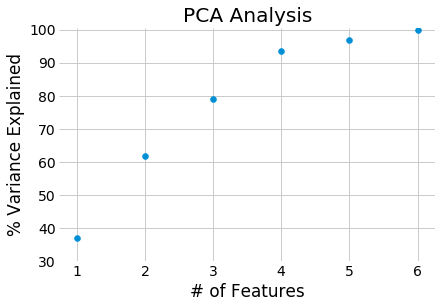

In [11]:
variance = p.explained_variance_ratio_ #calculate variance ratios
var=np.cumsum(np.round(p.explained_variance_ratio_, decimals=3)*100)
var #cumulative sum of variance explained with [n] features
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.ylim(30,100.5)
plt.scatter(x=np.arange(1,len(var)+1),y=var)
helper_save("PCA_Variance_Explained")

In [12]:
df = meta_df_withutoutliers.copy()
df["embedding_1"] = embedding[:,0]
df["embedding_2"] = embedding[:,1]
df["embedding_3"] = embedding[:,2]
df = pd.merge(df, data_withoutliers, how='inner',left_index=True, right_index=True)

In [13]:
def biplot(score,coeff,labels=None, PCs=(1,2)):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
            plt.xlim(-1,1)
            plt.ylim(-1,1)
            plt.xlabel("PC{}".format(PCs[0]))
            plt.ylabel("PC{}".format(PCs[1]))
            plt.grid()

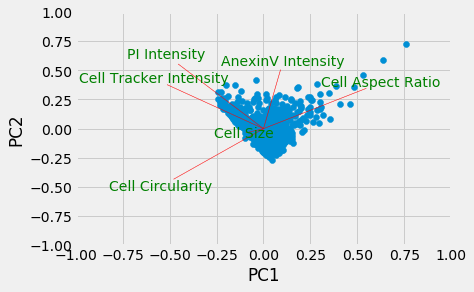

<Figure size 432x288 with 0 Axes>

In [14]:
 #Call the function. Use only the 2 PCs.
biplot(df[["embedding_1", "embedding_2"]].sample(1000, replace=False).values,
np.transpose(p.components_[0:2, :]),
labels=data.columns.values)
plt.show()
helper_save("nooutliers_biplot_pc1_pc2")

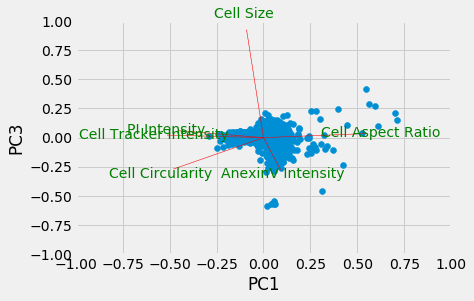

<Figure size 432x288 with 0 Axes>

In [15]:
#Call the function. Use only the 2 PCs.
biplot(df[["embedding_1", "embedding_3"]].sample(1000, replace=False).values,
np.transpose(p.components_[[0,2], :]),
labels=data.columns.values,
PCs = (1,3))

plt.show()
helper_save("nooutliers_biplot_pc1_pc3")

feat 0
0 0
feat 1
0 0
feat 2
1 0
feat 3
1 0
feat 4
2 0
feat 5
2 0


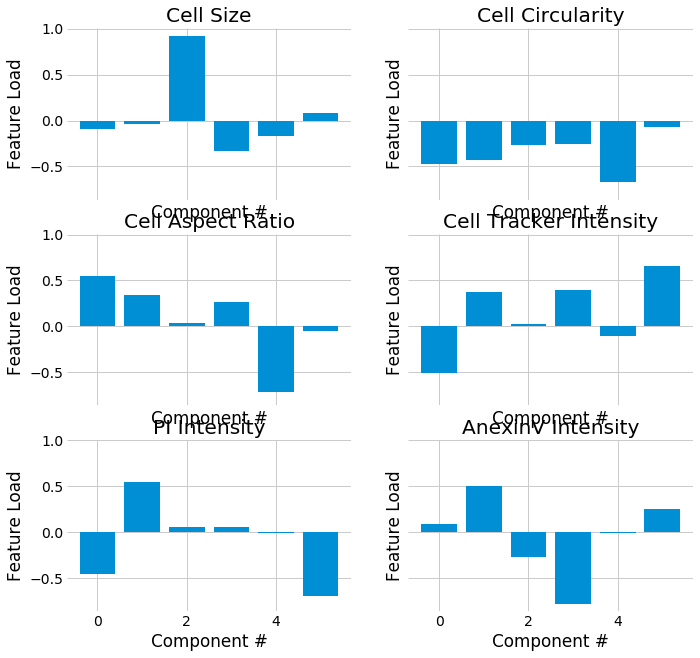

In [16]:
num_feat = p.components_.shape[1]
f, ax = plt.subplots(nrows=int(num_feat/2),ncols=2,squeeze=True, figsize=(10,10),sharex='all',sharey='all')
for feat in range(p.components_.shape[1]):
    if feat == 0:
        ax[0,0].bar(x=np.arange(p.components_.shape[0]),height=p.components_[:,feat])
        ax[0,0].set_title(data.columns.values[feat])
        ax[0,0].set_xlabel("Component #")
        ax[0,0].set_ylabel("Feature Load")
    else:
        ax[int(feat/2), feat%2].bar(x=np.arange(p.components_.shape[0]),height=p.components_[:,feat])
        ax[int(feat/2), feat%2].set_title(data.columns.values[feat])
        ax[int(feat/2), feat%2].set_xlabel("Component #")
        ax[int(feat/2), feat%2].set_ylabel("Feature Load")

    print('feat',feat)
    print(int(feat/2), feat%1)
    
    #plt.legend()
helper_save("nooutliers_PCloadings")

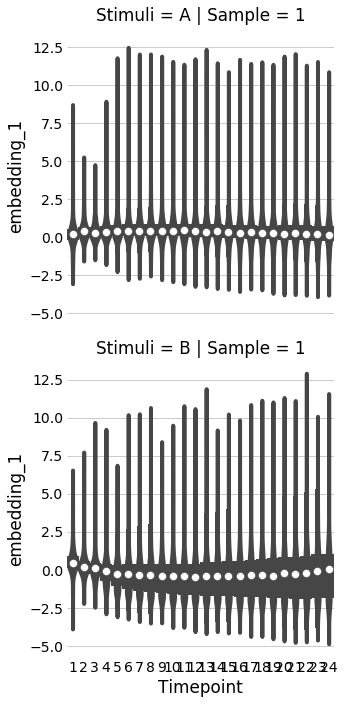

In [17]:
g = sns.catplot(x="Timepoint", y="embedding_1", col="Sample",row="Stimuli",data=df, dodge=False, kind='violin')
helper_save("nooutliers_PC1_by_time_violin")

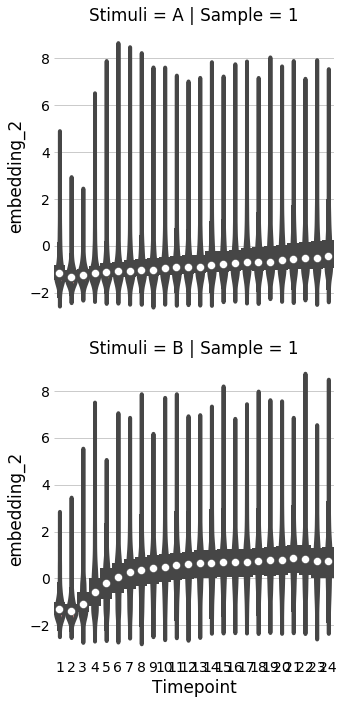

In [18]:
g = sns.catplot(x="Timepoint", y="embedding_2", col="Sample",row="Stimuli",data=df, dodge=False, 
                order=np.sort(df["Timepoint"].unique()),kind='violin')
helper_save("nooutliers_PC2_by_time_violin")

('A', 1)
('B', 1)


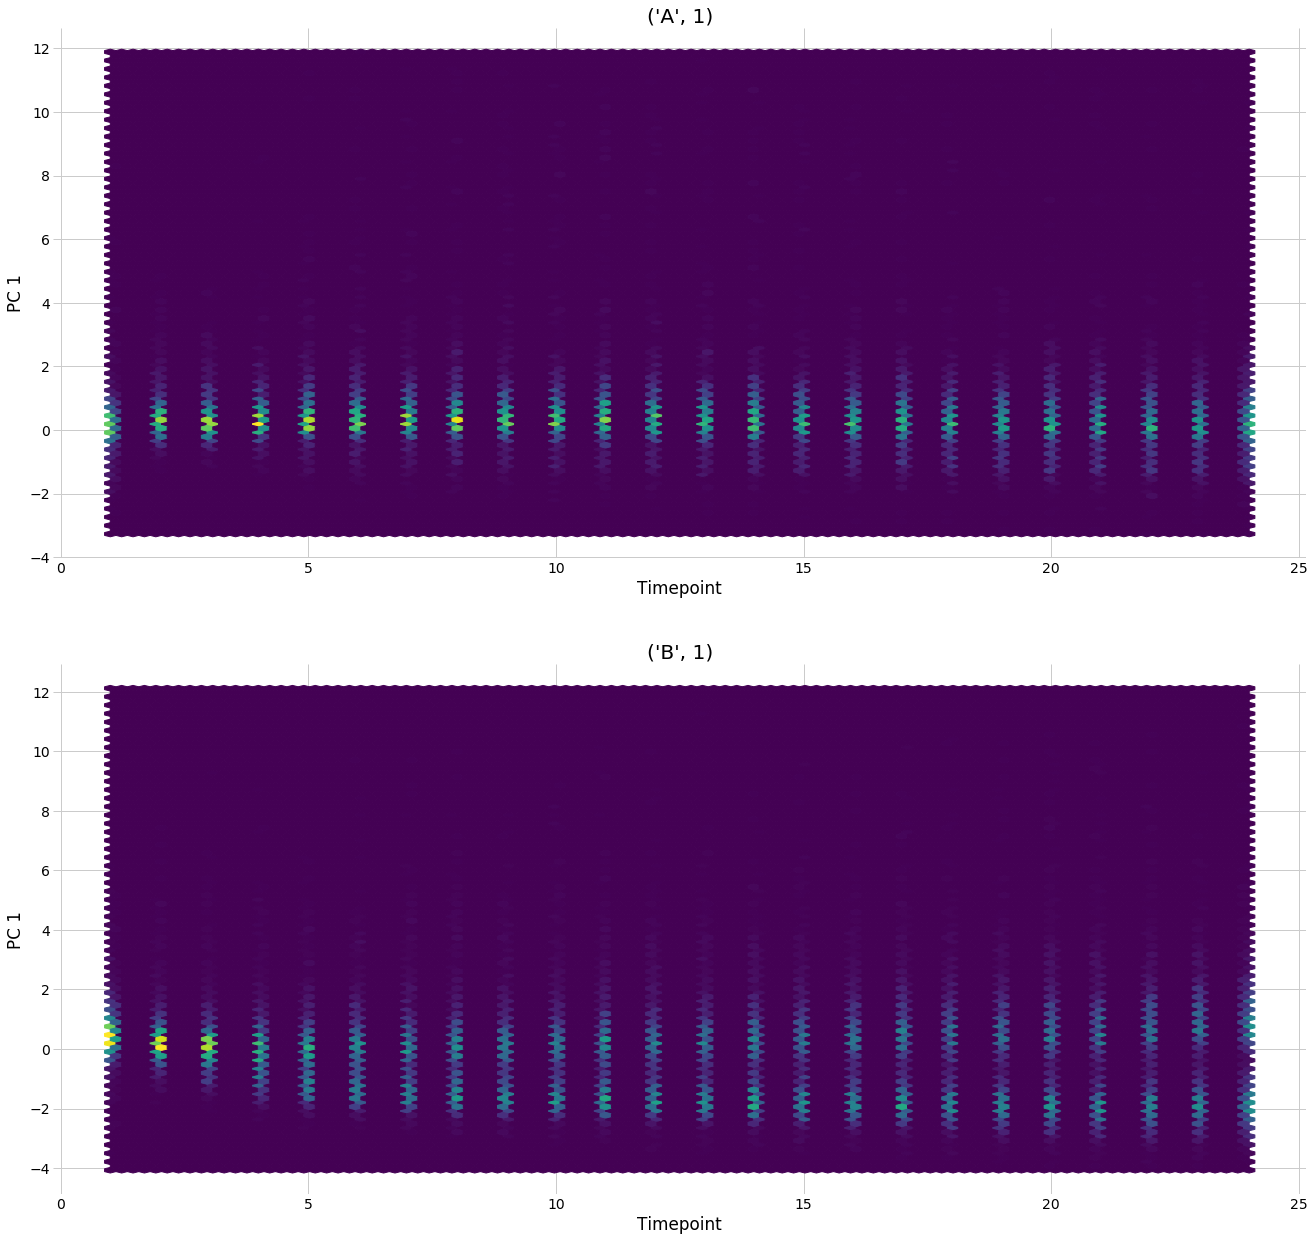

In [20]:
samp_ax = {name:i for i,name in enumerate(np.sort(df["Sample"].unique()))}
samp_ax

stim_ax = {name:i for i,name in enumerate(np.sort(df["Stimuli"].astype(str).unique()))}

f,axes = plt.subplots(nrows=len(df["Stimuli"].unique()), ncols=len(df["Sample"].unique()), squeeze=False,figsize=(20,20))
for g,val in df.groupby(["Stimuli","Sample"]):
    print(g)
    axes[stim_ax[g[0]], samp_ax[g[1]]].hexbin(val["Timepoint"], val["embedding_1"])
    axes[stim_ax[g[0]], samp_ax[g[1]]].set_title(g)
    axes[stim_ax[g[0]], samp_ax[g[1]]].set_xlabel("Timepoint")
    axes[stim_ax[g[0]], samp_ax[g[1]]].set_ylabel("PC 1")
helper_save("nooutliers_PC1_by_time_hexbin")

('A', 1)
('B', 1)


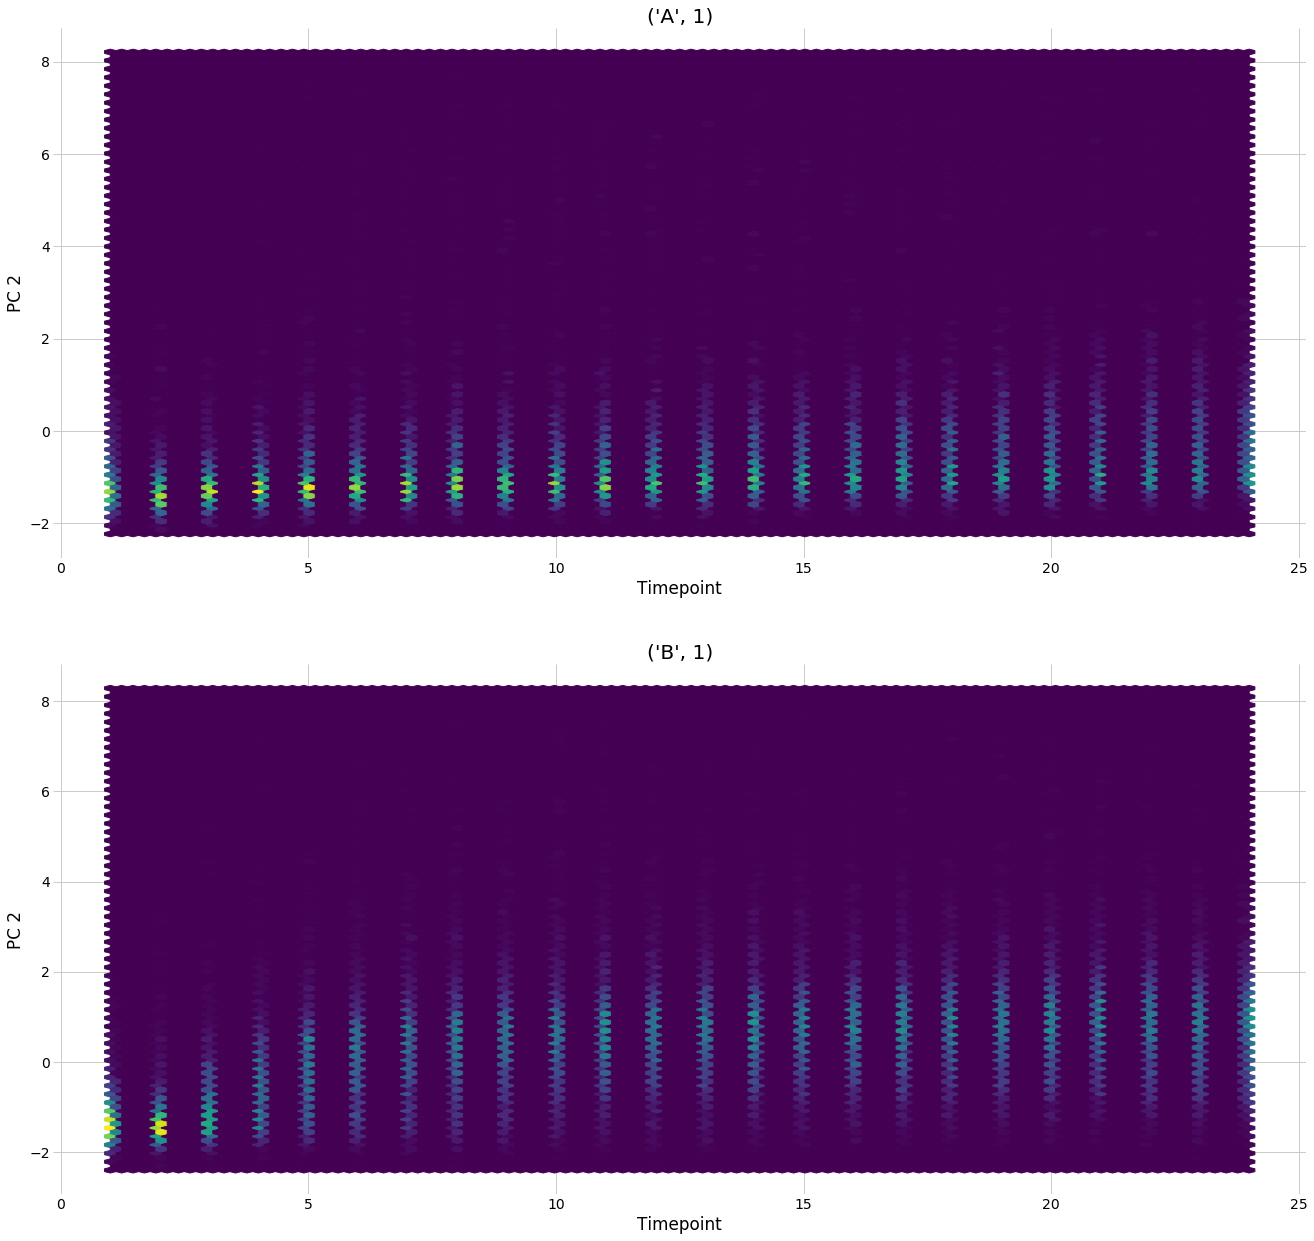

In [21]:
samp_ax = {name:i for i,name in enumerate(np.sort(df["Sample"].unique()))}
samp_ax

stim_ax = {name:i for i,name in enumerate(np.sort(df["Stimuli"].astype(str).unique()))}

f,axes = plt.subplots(nrows=len(df["Stimuli"].unique()), ncols=len(df["Sample"].unique()), squeeze=False, 
                      figsize=(20,20))
for g,val in df.groupby(["Stimuli","Sample"]):
    print(g)
    axes[stim_ax[g[0]], samp_ax[g[1]]].hexbin(val["Timepoint"], val["embedding_2"])
    axes[stim_ax[g[0]], samp_ax[g[1]]].set_title(g)
    axes[stim_ax[g[0]], samp_ax[g[1]]].set_xlabel("Timepoint")
    axes[stim_ax[g[0]], samp_ax[g[1]]].set_ylabel("PC 2")
helper_save("nooutliers_PC2_by_time_hexbin")

In [22]:
# n_iter = 5
# n_sample = 1000
# # Create figures
# color_labels = df["Stimuli Names"].unique()
# rgb_values = (sns.color_palette("Set2", len(color_labels)))
# color_map = dict(zip(color_labels, rgb_values))
# for i in range(n_iter):
#     curr_df = df.sample(n = 10000, replace=False)
#     plt.figure(figsize=(15,15))
#     pallete=sns.color_palette("bright", len(color_labels))
#     sns.scatterplot(data=curr_df,x="embedding_1", y="embedding_2",␣palette=pallete, hue='Stimuli Names', size=0.5)
#     plt.legend(loc='upper right')
#     for i in data.columns.values:
#         plt.figure(figsize=(15,15))
#         pallete=sns.color_palette("bright", len(color_labels))
#         sns.scatterplot(data=curr_df,x="embedding_1", y="embedding_2", hue=i, style="Genotype", size=0.5)
#         plt.legend(loc='upper right')